# Atividade 4 – Resposta a um Sinal Senoidal

Nesta atividade, um sinal senoidal será gerado com as seguintes características:
- **Frequência:** 200 Hz;
- **Número de períodos:** 20 (suficiente para observar a resposta transitória e atingir o regime permanente);
- **Amplitude:** 2 V (equivalente a 4 Vpp).

Com este sinal, serão simulados dois modelos do alto-falante:
1. **Modelo Linear:** onde o fator de força \(B_l\) é constante.
2. **Modelo Não Linear:** onde \(B_l\) varia com o deslocamento do cone, seguindo uma função polinomial de ordem 2 entre 75% e 150% do deslocamento máximo obtido no modelo linear.

Os resultados serão comparados em termos da resposta transitória e do regime permanente, tanto no domínio do tempo quanto no espectro (FFT), para evidenciar as diferenças comportamentais entre os dois modelos.


In [1]:
# =============================================================================
# Importação de pacotes
# =============================================================================
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.io.wavfile import write, read
from scipy.fft import fft, fftfreq

In [2]:
# =============================================================================
# Seção 1: Parâmetros do sistema e geração do sinal de entrada
# =============================================================================
# Parâmetros físicos do sistema
m  = 14.35e-3   # Massa (kg)
b  = 0.786      # Amortecimento (kg/s)
k  = 1852       # Rigidez (N/m)
Bl = 4.95       # Constante eletromagnética (N/A)
L  = 266e-6     # Indutância (H)
R  = 3.3        # Resistência (Ohms)

# Parâmetros do sinal de entrada
f_signal = 200           # Frequência do sinal (Hz)
n_periods = 20           # Número de períodos
amp = 2.0                # Amplitude (V) – sinal senoidal com 4 Vpp
duration = n_periods / f_signal  # Duração do sinal
fs = 200e3               # Taxa de amostragem (Hz)
t = np.arange(0, duration, 1/fs)
sinal = amp * np.sin(2 * np.pi * f_signal * t)

# Cria função interpoladora para o sinal de entrada
ch0 = interp1d(t, sinal, fill_value="extrapolate")

In [3]:
# =============================================================================
# Seção 2: Simulação do modelo linear
# =============================================================================
def fch_lin(t, x):
    """
    Função que define o modelo linear do alto-falante.
    Entrada: sinal senoidal (via função ch0).
    x = [corrente, posição, velocidade]
    """
    i, pos, vel = x
    # Matrizes A e B fixas (modelo linear)
    A = np.array([
        [-R / L,     0,       -Bl / L],
        [0,          0,        1],
        [Bl / m, -k / m,   -b / m]
    ])
    Bvec = np.array([1 / L, 0, 0])
    return A @ x + Bvec * ch0(t)

# Condição inicial nula
x0 = [0.0, 0.0, 0.0]
# Solução numérica do sistema linear
sol_lin = solve_ivp(fch_lin, [0, duration], x0, t_eval=t)
# Obtém a máxima excursão (valor absoluto do deslocamento)
x_max = np.max(np.abs(sol_lin.y[1]))

In [4]:
# =============================================================================
# Seção 3: Definição dos limites de não linearidade e do modelo não linear
# =============================================================================
# Limites de não linearidade baseados na resposta linear
x1 = 0.75 * x_max
x2 = 1.5 * x_max

def B_l(x):
    """
    Função que define o comportamento não linear do fator de força.
    - Se |x| <= x1, opera de forma linear (retorna Bl).
    - Se |x| >= x2, a força é anulada (retorna 0).
    - Entre x1 e x2, ocorre uma variação quadrática.
    """
    if abs(x) <= x1:
        return Bl
    elif abs(x) >= x2:
        return 0.0
    else:
        a = Bl / (x2 - x1)**2
        if x > 0:
            return a * (x - x2)**2
        else:
            return a * (x + x2)**2

def fch_nl(t, x):
    """
    Função que define o modelo não linear do alto-falante.
    Aqui, o valor de B_l é calculado com base na posição x.
    """
    i, pos, vel = x
    Bl_val = B_l(pos)
    A = np.array([
        [-R / L,     0,       -Bl_val / L],
        [0,          0,        1],
        [Bl_val / m, -k / m,   -b / m]
    ])
    Bvec = np.array([1 / L, 0, 0])
    return A @ x + Bvec * ch0(t)

# Solução numérica do modelo não linear
sol_nl = solve_ivp(fch_nl, [0, duration], x0, t_eval=t)

In [5]:
# =============================================================================
# Seção 4: Conversão dos sinais para arquivo WAV e salvamento
# =============================================================================
def to_wav(signal, fs):
    """
    Função que normaliza e converte o sinal para formato .wav (16 bits).
    """
    norm = signal / np.max(np.abs(signal))
    return np.int16(norm * 32767)

# Converte a entrada, a resposta linear e a resposta não linear
entrada_wav    = to_wav(sinal, fs)
saida_lin_wav  = to_wav(sol_lin.y[1], fs)  # posição (deslocamento) do modelo linear
saida_nl_wav   = to_wav(sol_nl.y[1], fs)   # posição (deslocamento) do modelo não linear

# Salva os arquivos .wav
write("entrada_sinal.wav", int(fs), entrada_wav)
write("saida_linear.wav", int(fs), saida_lin_wav)
write("saida_nao_linear.wav", int(fs), saida_nl_wav)

In [6]:
# =============================================================================
# Seção 5: Análise Espectral (FFT) das respostas
# =============================================================================
def compute_fft(signal, fs):
    """
    Computa a FFT do sinal e retorna as frequências e a magnitude.
    Considera apenas as frequências não-negativas.
    """
    yf = fft(signal)
    xf = fftfreq(len(signal), 1/fs)
    idx = np.where(xf >= 0)
    return xf[idx], np.abs(yf[idx])

# Calcula FFT para a entrada, saída linear e saída não linear
xf_in,  mag_in  = compute_fft(sinal, fs)
xf_lin, mag_lin = compute_fft(sol_lin.y[1], fs)
xf_nl,  mag_nl  = compute_fft(sol_nl.y[1], fs)

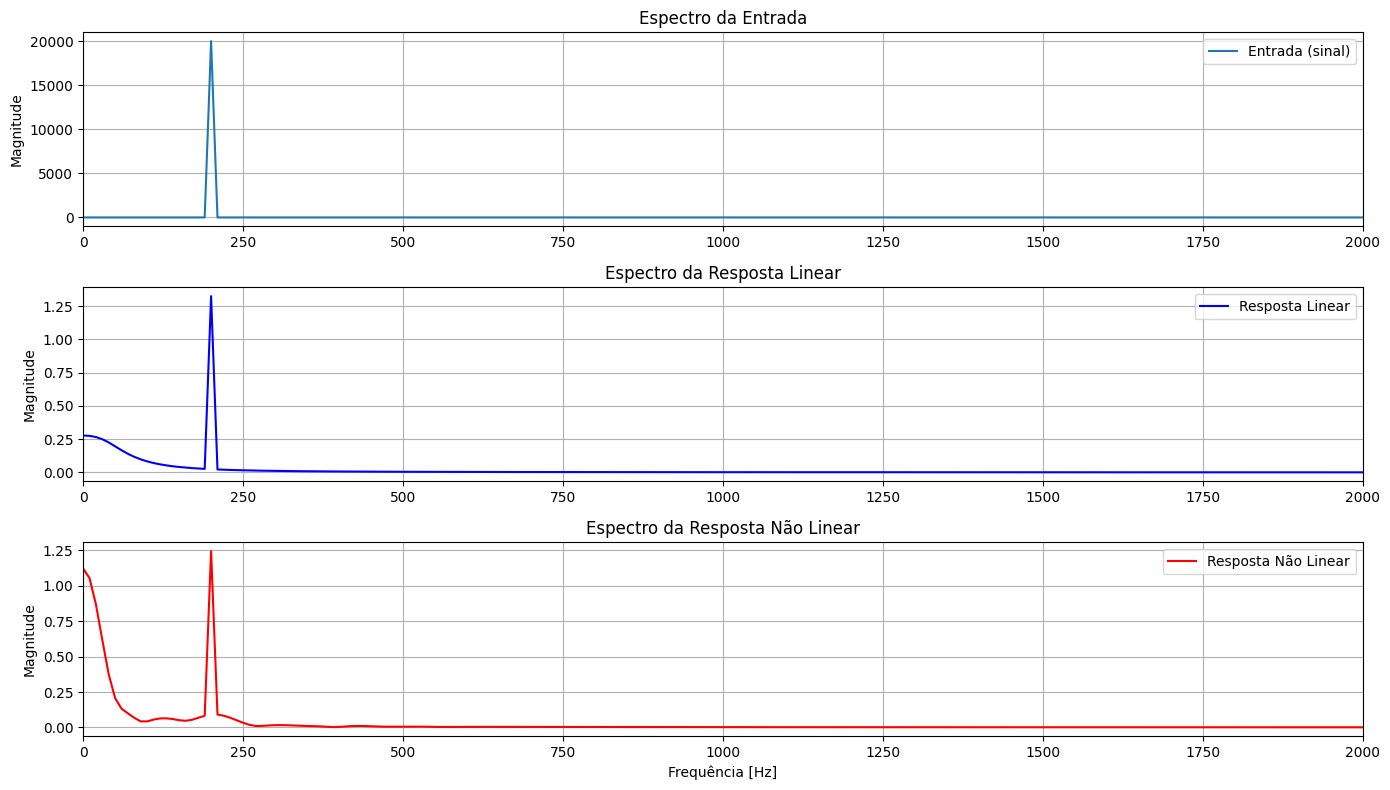

In [7]:
# =============================================================================
# Seção 6: Plot dos espectros (FFT)
# =============================================================================
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(xf_in, mag_in, label="Entrada (sinal)")
plt.xlim(0, 2000)
plt.ylabel("Magnitude")
plt.title("Espectro da Entrada")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(xf_lin, mag_lin, label="Resposta Linear", color="blue")
plt.xlim(0, 2000)
plt.ylabel("Magnitude")
plt.title("Espectro da Resposta Linear")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(xf_nl, mag_nl, label="Resposta Não Linear", color="red")
plt.xlim(0, 2000)
plt.xlabel("Frequência [Hz]")
plt.ylabel("Magnitude")
plt.title("Espectro da Resposta Não Linear")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

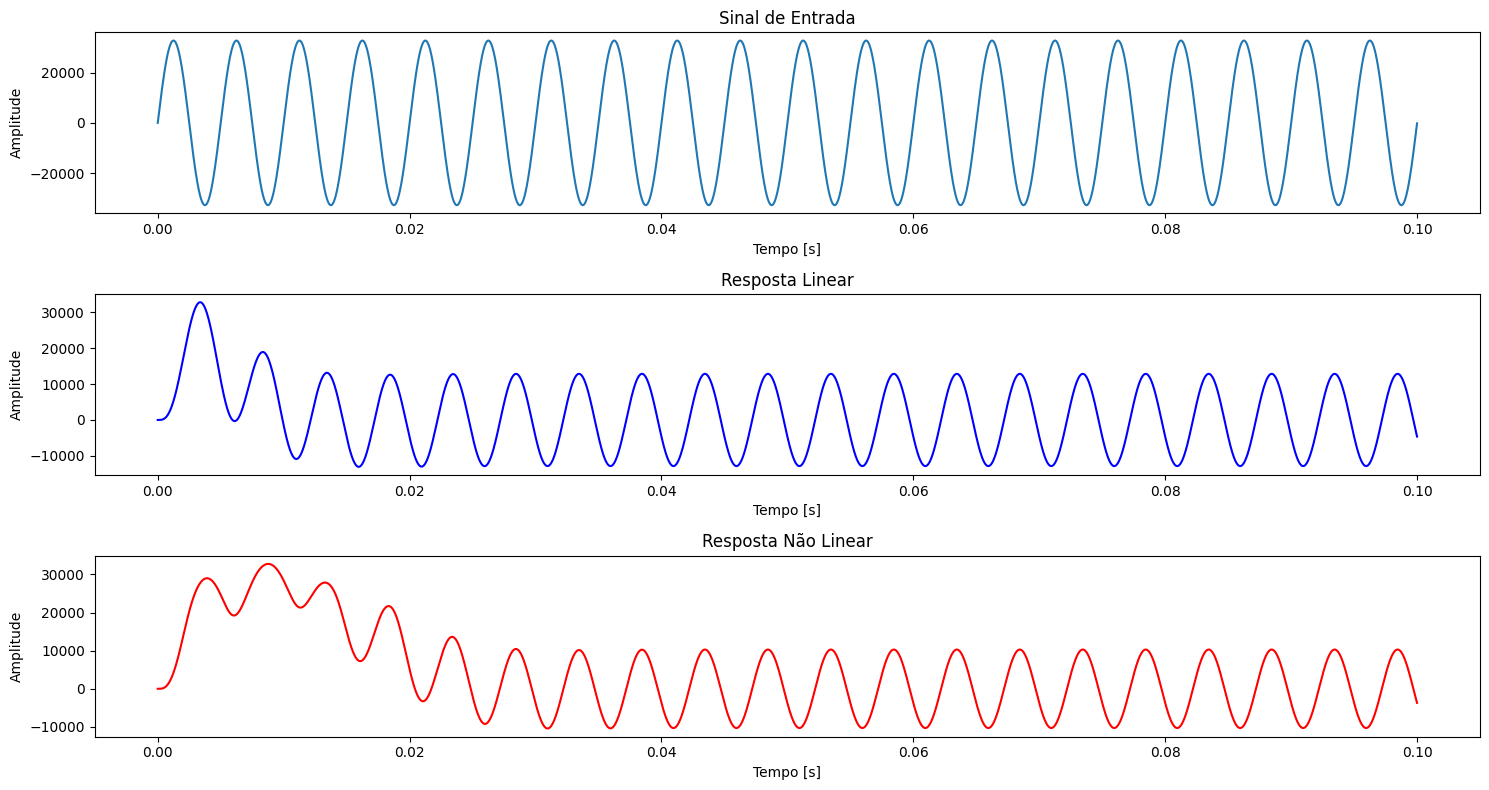

In [8]:
# =============================================================================
# Seção 7: Carregamento e Plot dos Áudios Salvos
# =============================================================================
def load_wav(filename):
    """
    Função para carregar um arquivo WAV e normalizar o sinal.
    Se o áudio for estéreo, utiliza apenas o primeiro canal.
    """
    rate, data = read(filename)
    if len(data.shape) > 1:
        data = data[:, 0]
    time_axis = np.linspace(0, len(data) / rate, num=len(data))
    return time_axis, data, rate

# Carrega os arquivos de áudio salvos
time_in,  data_in,  rate_in  = load_wav('entrada_sinal.wav')
time_lin, data_lin, rate_lin = load_wav('saida_linear.wav')
time_nl,  data_nl,  rate_nl  = load_wav('saida_nao_linear.wav')

plt.figure(figsize=(15, 8))

plt.subplot(3, 1, 1)
plt.plot(time_in, data_in)
plt.title('Sinal de Entrada')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 2)
plt.plot(time_lin, data_lin, color="blue")
plt.title('Resposta Linear')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 3)
plt.plot(time_nl, data_nl, color="red")
plt.title('Resposta Não Linear')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

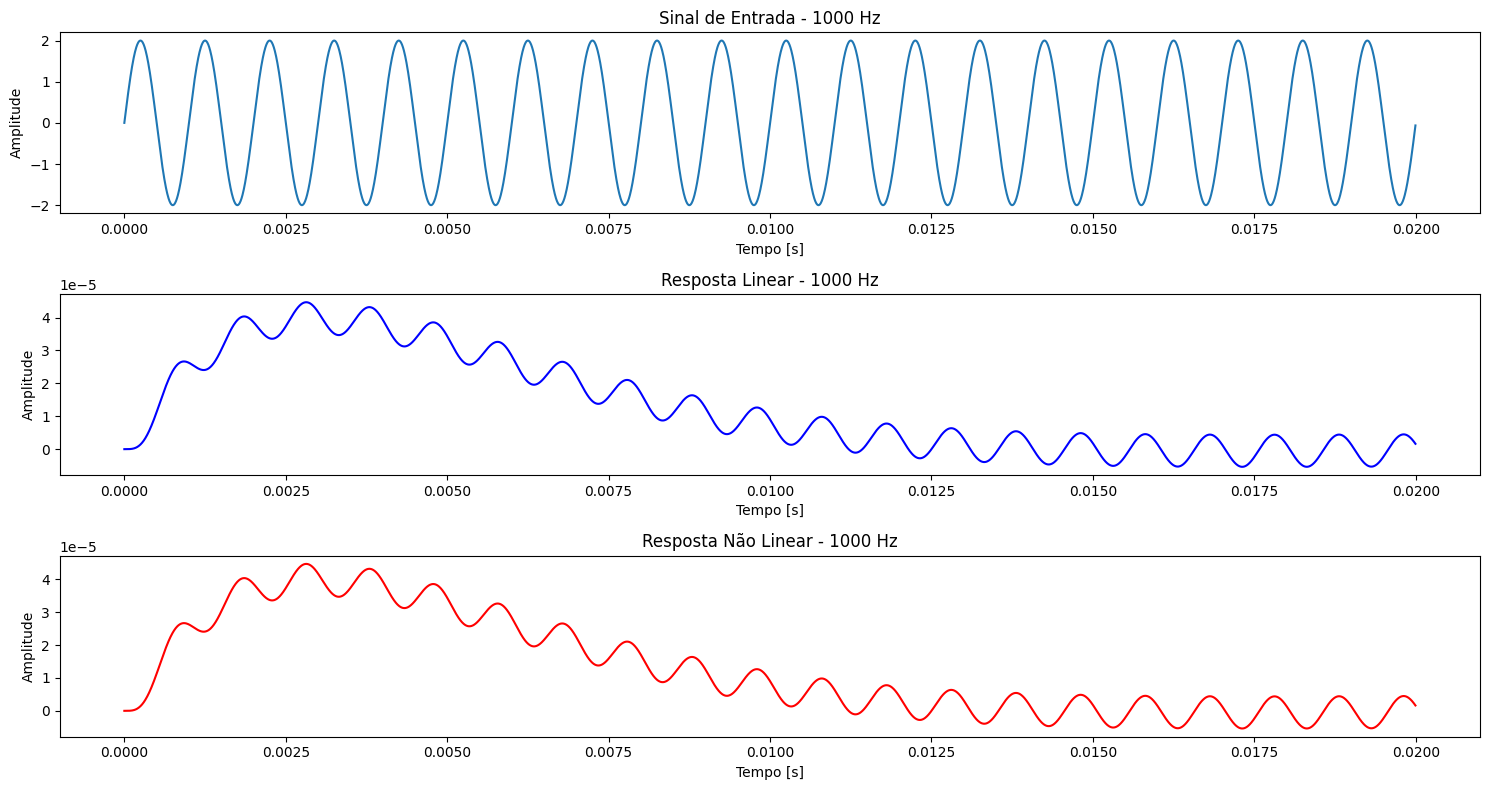

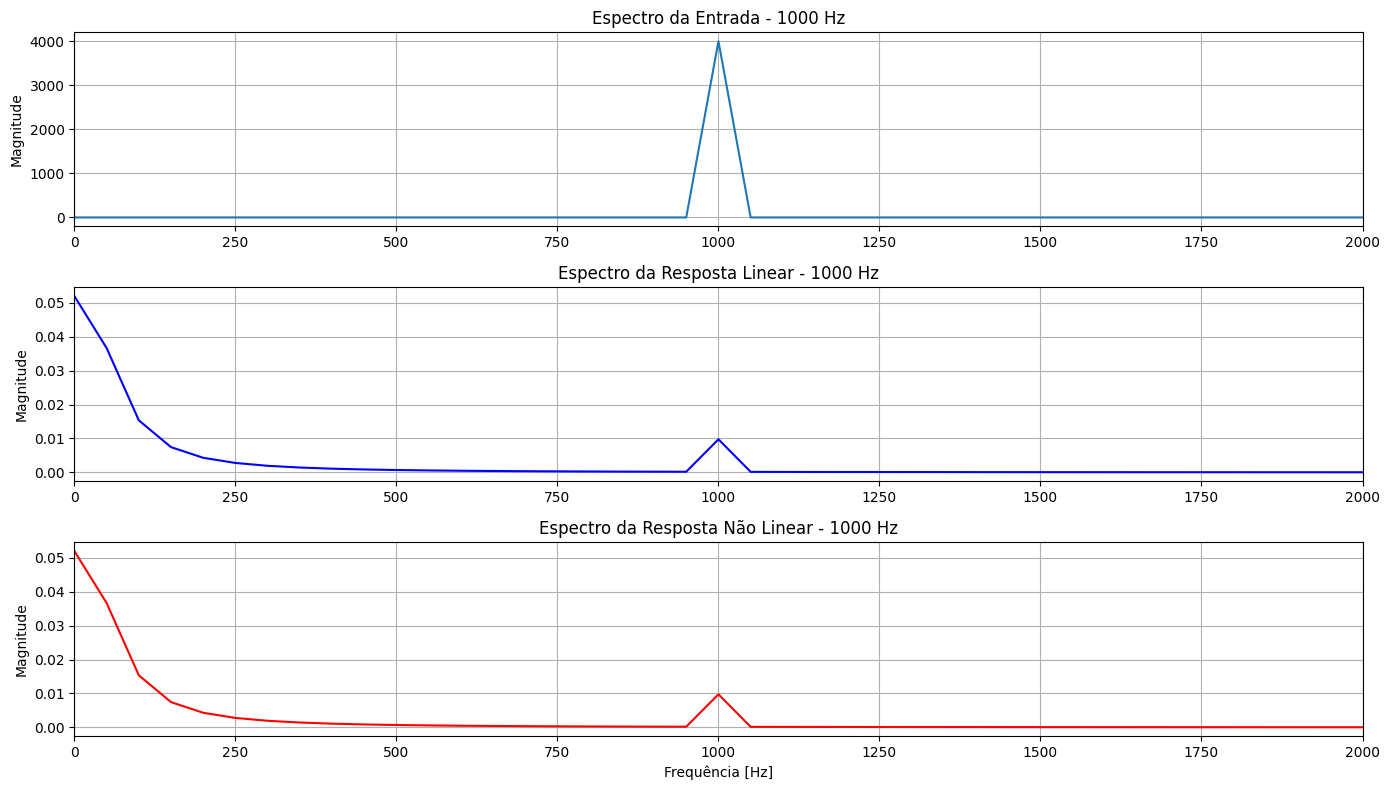

In [11]:
# =============================================================================
# Seção Extra: Simulação para um sinal senoidal de 1000 Hz (Extra)
# =============================================================================
# Definindo os parâmetros para o sinal extra
f_ex = 1000                # Frequência extra: 1000 Hz
n_periods_ex = 20          # Número de períodos
duration_ex = n_periods_ex / f_ex    # Duração do sinal
t_ex = np.arange(0, duration_ex, 1/fs) # Vetor de tempo para o sinal extra
sinal_ex = amp * np.sin(2 * np.pi * f_ex * t_ex)  # Geração do sinal extra
ch0_ex = interp1d(t_ex, sinal_ex, fill_value="extrapolate")

# --- Modelo Linear Extra ---
def fch_lin_ex(t, x):
    i, pos, vel = x
    A_ex = np.array([
        [-R / L,     0,       -Bl / L],
        [0,          0,        1],
        [Bl / m,  -k / m,   -b / m]
    ])
    Bvec_ex = np.array([1 / L, 0, 0])
    return A_ex @ x + Bvec_ex * ch0_ex(t)

sol_lin_ex = solve_ivp(fch_lin_ex, [0, duration_ex], x0, t_eval=t_ex)

# --- Modelo Não Linear Extra ---
def fch_nl_ex(t, x):
    i, pos, vel = x
    Bl_val_ex = B_l(pos)
    A_ex = np.array([
        [-R / L,         0,       -Bl_val_ex / L],
        [0,              0,        1],
        [Bl_val_ex / m, -k / m,   -b / m]
    ])
    Bvec_ex = np.array([1 / L, 0, 0])
    return A_ex @ x + Bvec_ex * ch0_ex(t)

sol_nl_ex = solve_ivp(fch_nl_ex, [0, duration_ex], x0, t_eval=t_ex)

# =============================================================================
# Plot: Domínio do Tempo para o Sinal de 1000 Hz
# =============================================================================
plt.figure(figsize=(15, 8))

plt.subplot(3, 1, 1)
plt.plot(t_ex, sinal_ex)
plt.title('Sinal de Entrada - 1000 Hz')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 2)
plt.plot(t_ex, sol_lin_ex.y[1], color="blue")
plt.title('Resposta Linear - 1000 Hz')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 3)
plt.plot(t_ex, sol_nl_ex.y[1], color="red")
plt.title('Resposta Não Linear - 1000 Hz')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

# =============================================================================
# Plot: Análise Espectral (FFT) para o Sinal de 1000 Hz
# =============================================================================
def compute_fft(signal, fs):
    yf = fft(signal)
    xf = fftfreq(len(signal), 1/fs)
    idx = np.where(xf >= 0)
    return xf[idx], np.abs(yf[idx])

# Calculando as FFTs do sinal de entrada, da resposta linear e da resposta não linear
xf_ex_in, mag_ex_in   = compute_fft(sinal_ex, fs)
xf_ex_lin, mag_ex_lin = compute_fft(sol_lin_ex.y[1], fs)
xf_ex_nl, mag_ex_nl   = compute_fft(sol_nl_ex.y[1], fs)

plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(xf_ex_in, mag_ex_in, label="Entrada (1000 Hz)")
plt.xlim(0, 2000)
plt.ylabel("Magnitude")
plt.title("Espectro da Entrada - 1000 Hz")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(xf_ex_lin, mag_ex_lin, label="Saída Linear", color="blue")
plt.xlim(0, 2000)
plt.ylabel("Magnitude")
plt.title("Espectro da Resposta Linear - 1000 Hz")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(xf_ex_nl, mag_ex_nl, label="Saída Não Linear", color="red")
plt.xlim(0, 2000)
plt.xlabel("Frequência [Hz]")
plt.ylabel("Magnitude")
plt.title("Espectro da Resposta Não Linear - 1000 Hz")
plt.grid(True)

plt.tight_layout()
plt.show()